<a href="https://colab.research.google.com/github/arthurpeter/Machine_Learning/blob/main/Notiuni_fundamentale_de_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Setul de date

Bolile cardiovasculare(BCV) sunt cea mai importantă cauză de deces la nivel global, provocând aproximativ 17,9 milioane de vieți pierdute în fiecare an, ceea ce reprezintă 31% din toate decesele la nivel mondial. Insuficiența cardiacă este un eveniment comun cauzat de BCV, iar acest set de date conține 12 caracteristici care pot fi utilizate pentru a prezice mortalitatea cauzată de insuficiența cardiacă.

Cele mai multe boli cardiovasculare pot fi prevenite prin abordarea factorilor de risc comportamentali, cum ar fi consumul de tutun, dieta nesănătoasă și obezitatea, inactivitatea fizică și consumul nociv de alcool, prin strategii la nivel de populație.

Persoanele cu boli cardiovasculare sau cele care au un risc cardiovascular ridicat (datorită prezenței unuia sau mai multor factori de risc, cum ar fi hipertensiunea, diabetul, hiperlipidemia sau o boală deja stabilită) au nevoie de detectare timpurie și gestionare, în care un model de învățare automată poate fi de mare ajutor.

In [3]:
!unzip Data.zip -d Data

Archive:  Data.zip
   creating: Data/Brain Tumor Data Set/
   creating: Data/Brain Tumor Data Set/Brain Tumor/
  inflating: Data/Brain Tumor Data Set/Brain Tumor/Cancer (1).jpg  
  inflating: Data/Brain Tumor Data Set/Brain Tumor/Cancer (1).png  
  inflating: Data/Brain Tumor Data Set/Brain Tumor/Cancer (1).tif  
  inflating: Data/Brain Tumor Data Set/Brain Tumor/Cancer (10).jpg  
  inflating: Data/Brain Tumor Data Set/Brain Tumor/Cancer (10).tif  
  inflating: Data/Brain Tumor Data Set/Brain Tumor/Cancer (100).jpg  
  inflating: Data/Brain Tumor Data Set/Brain Tumor/Cancer (1000).jpg  
  inflating: Data/Brain Tumor Data Set/Brain Tumor/Cancer (1001).jpg  
  inflating: Data/Brain Tumor Data Set/Brain Tumor/Cancer (1002).JPG  
  inflating: Data/Brain Tumor Data Set/Brain Tumor/Cancer (1003).jpg  
  inflating: Data/Brain Tumor Data Set/Brain Tumor/Cancer (1004).jpg  
  inflating: Data/Brain Tumor Data Set/Brain Tumor/Cancer (1005).jpg  
  inflating: Data/Brain Tumor Data Set/Brain Tumor/

### Supervised Learning
Clasificare

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
df = pd.read_csv('Data/heart_failure_clinical_records_dataset.csv')

In [6]:
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [8]:
print(f'Setul de date are {df.shape[0]} randuri si {df.shape[1]} coloane')

Setul de date are 299 randuri si 13 coloane


#### Impartirea datelor

In [7]:
from sklearn.model_selection import train_test_split

X = df.drop('DEATH_EVENT', axis=1)
y = df['DEATH_EVENT']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2024)
train_df = pd.concat([X_train.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)
train_df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,64.0,0,1610,0,60,0,242000.0,1.0,137,1,0,113,0
1,65.0,1,135,0,35,1,290000.0,0.8,134,1,0,194,0
2,60.0,1,2281,1,40,0,283000.0,1.0,141,0,0,187,0
3,65.0,0,395,1,25,0,265000.0,1.2,136,1,1,154,1
4,50.0,1,249,1,35,1,319000.0,1.0,128,0,0,28,1


#### EDA

In [9]:
descriptive = pd.DataFrame(round(train_df.describe(include='all'),3).T)

descriptive

,count,mean,std,min,25%,50%,75%,max
age,239.0,61.022,11.981,40.0,52.0,60.0,70.00,95.0
anaemia,239.0,0.452,0.499,0.0,0.0,0.0,1.00,1.0
creatinine_phosphokinase,239.0,606.481,1001.323,23.0,114.0,260.0,582.00,7861.0
diabetes,239.0,0.439,0.497,0.0,0.0,0.0,1.00,1.0
ejection_fraction,239.0,38.410,11.851,14.0,30.0,38.0,45.00,80.0
high_blood_pressure,239.0,0.356,0.480,0.0,0.0,0.0,1.00,1.0
platelets,239.0,264928.773,98741.346,25100.0,214000.0,257000.0,305000.00,850000.0
serum_creatinine,239.0,1.398,0.991,0.6,0.9,1.1,1.45,9.0
serum_sodium,239.0,136.703,4.523,113.0,134.0,137.0,140.00,148.0
sex,239.0,0.653,0.477,0.0,0.0,1.0,1.00,1.0


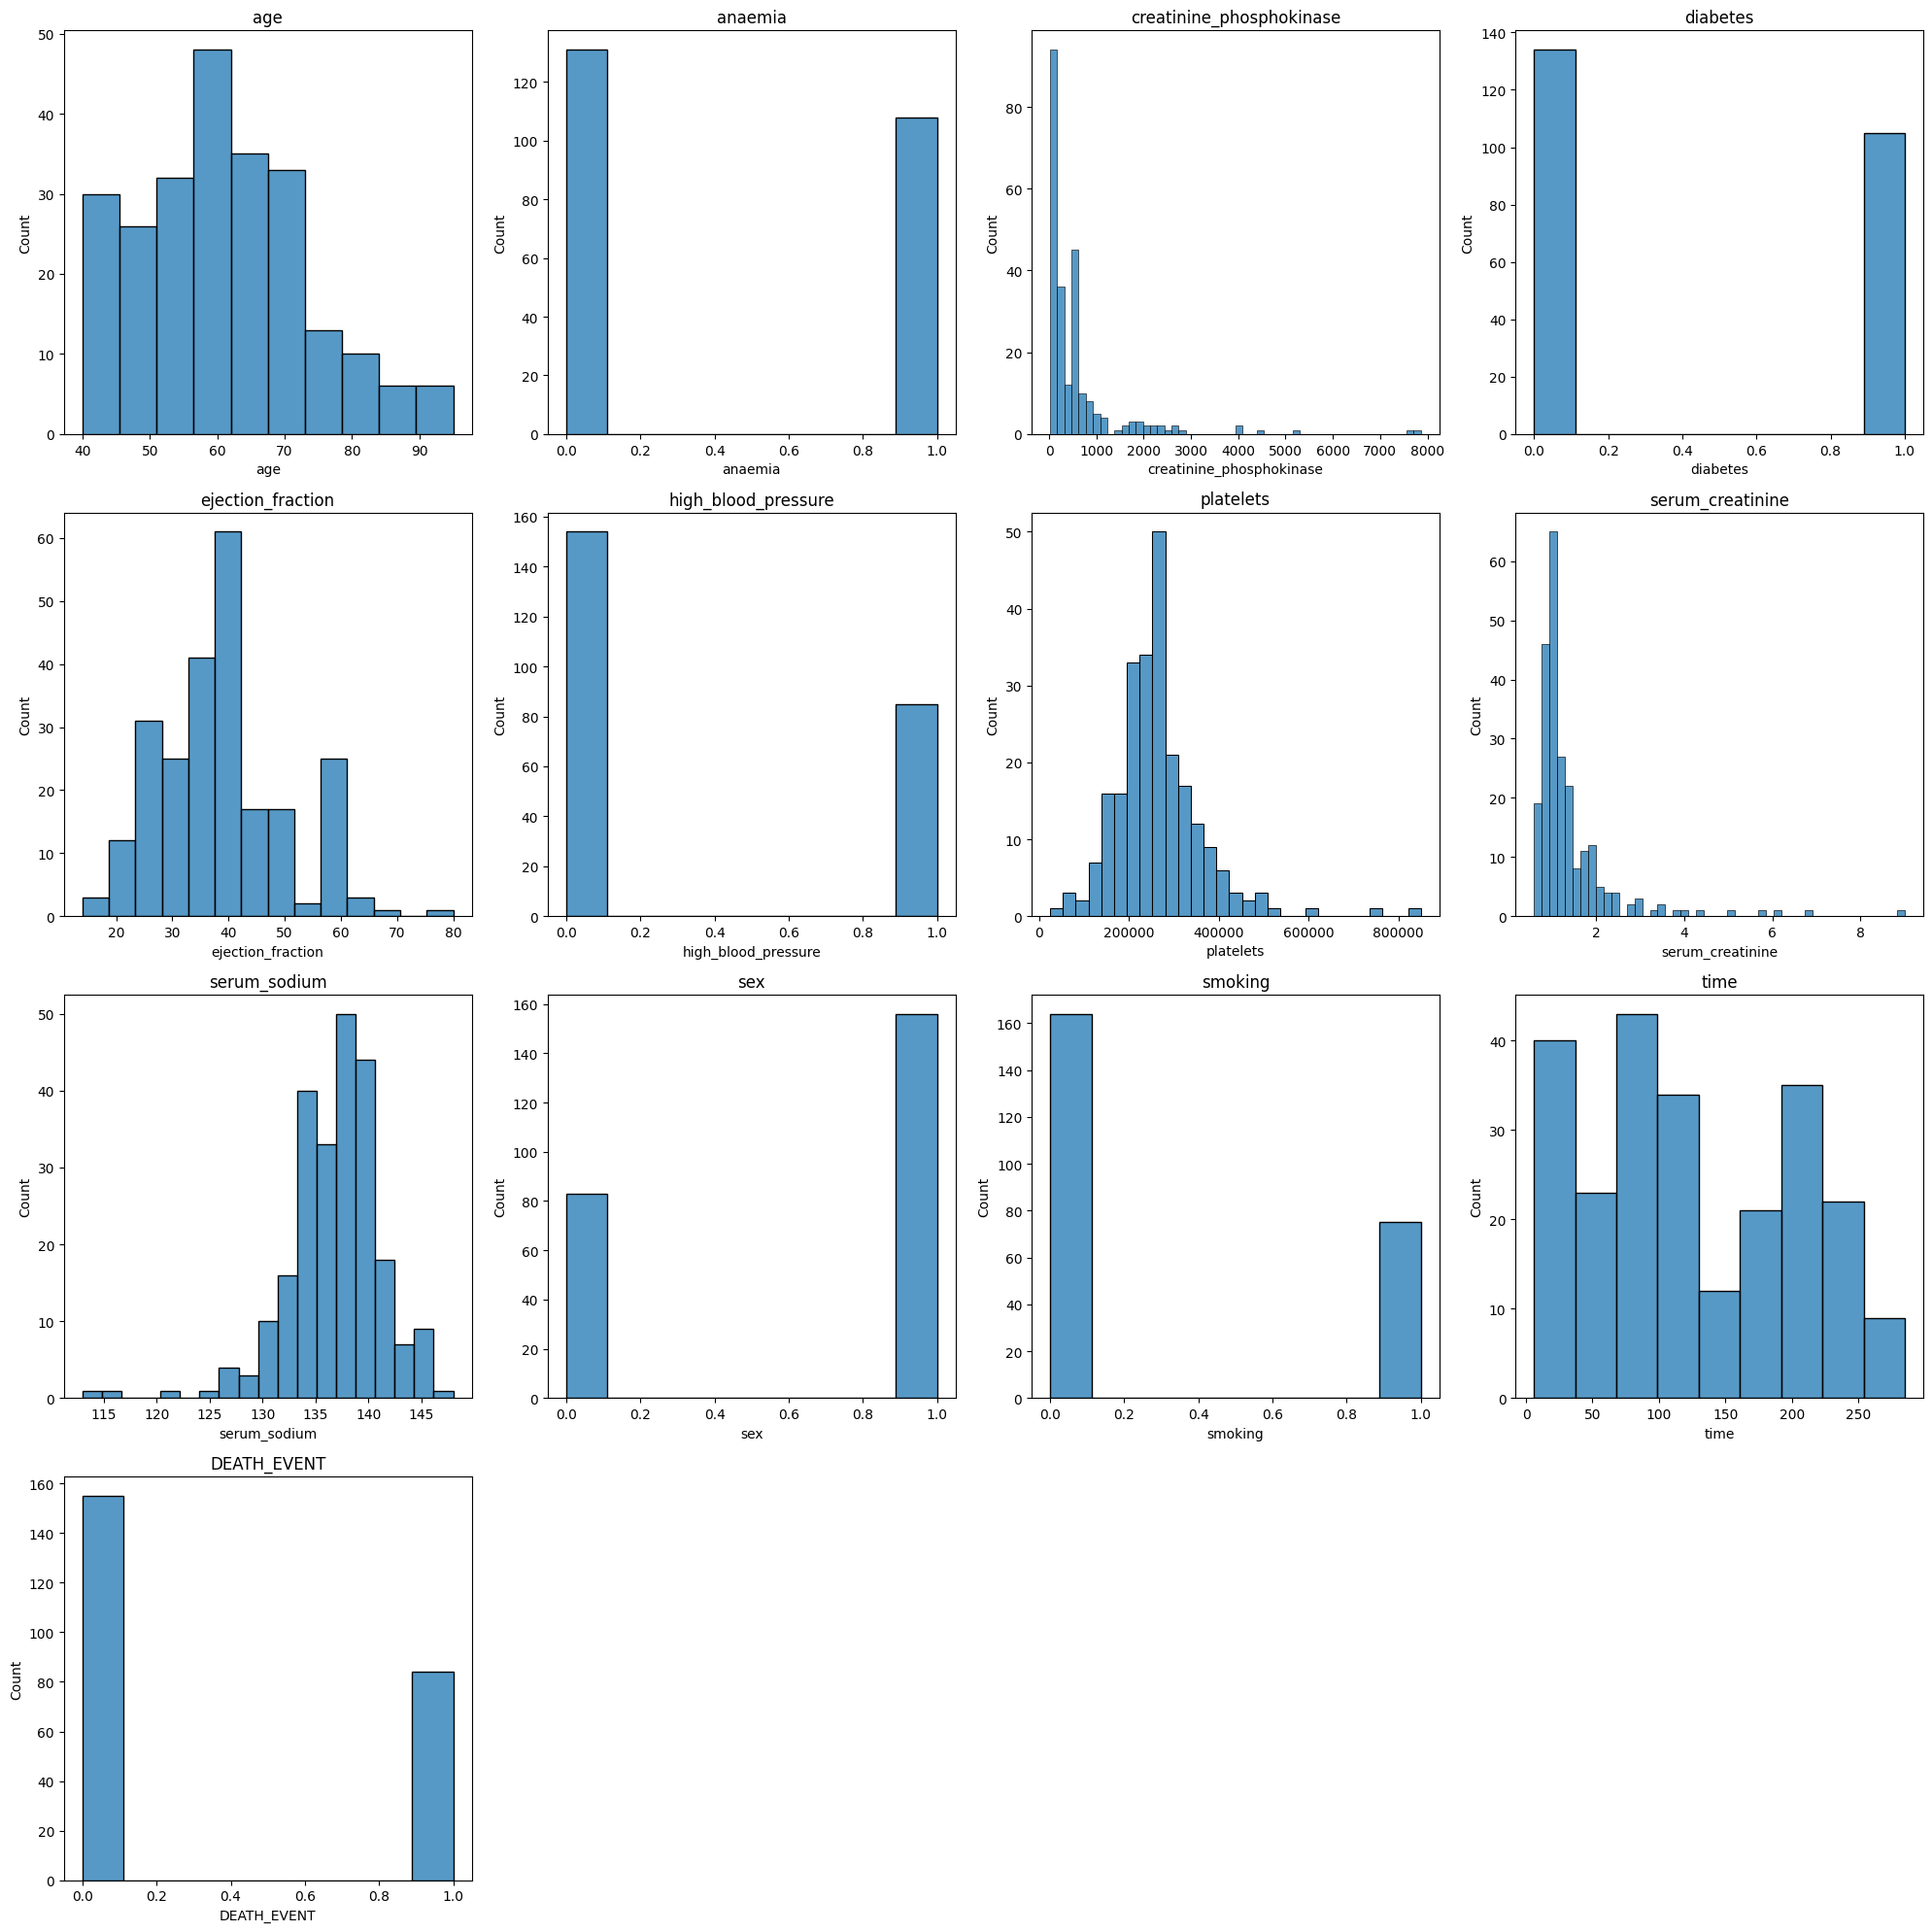

In [10]:
fig, ax = plt.subplots(4,4, figsize=(20,20))

ax = ax.flatten()

for i,var in enumerate(train_df.columns):

    sns.histplot(data=train_df, x=var, ax=ax[i])

    ax[i].set_title(var)

for j in range(len(train_df.columns), len(ax)):
    fig.delaxes(ax[j])

plt.tight_layout()
plt.show()

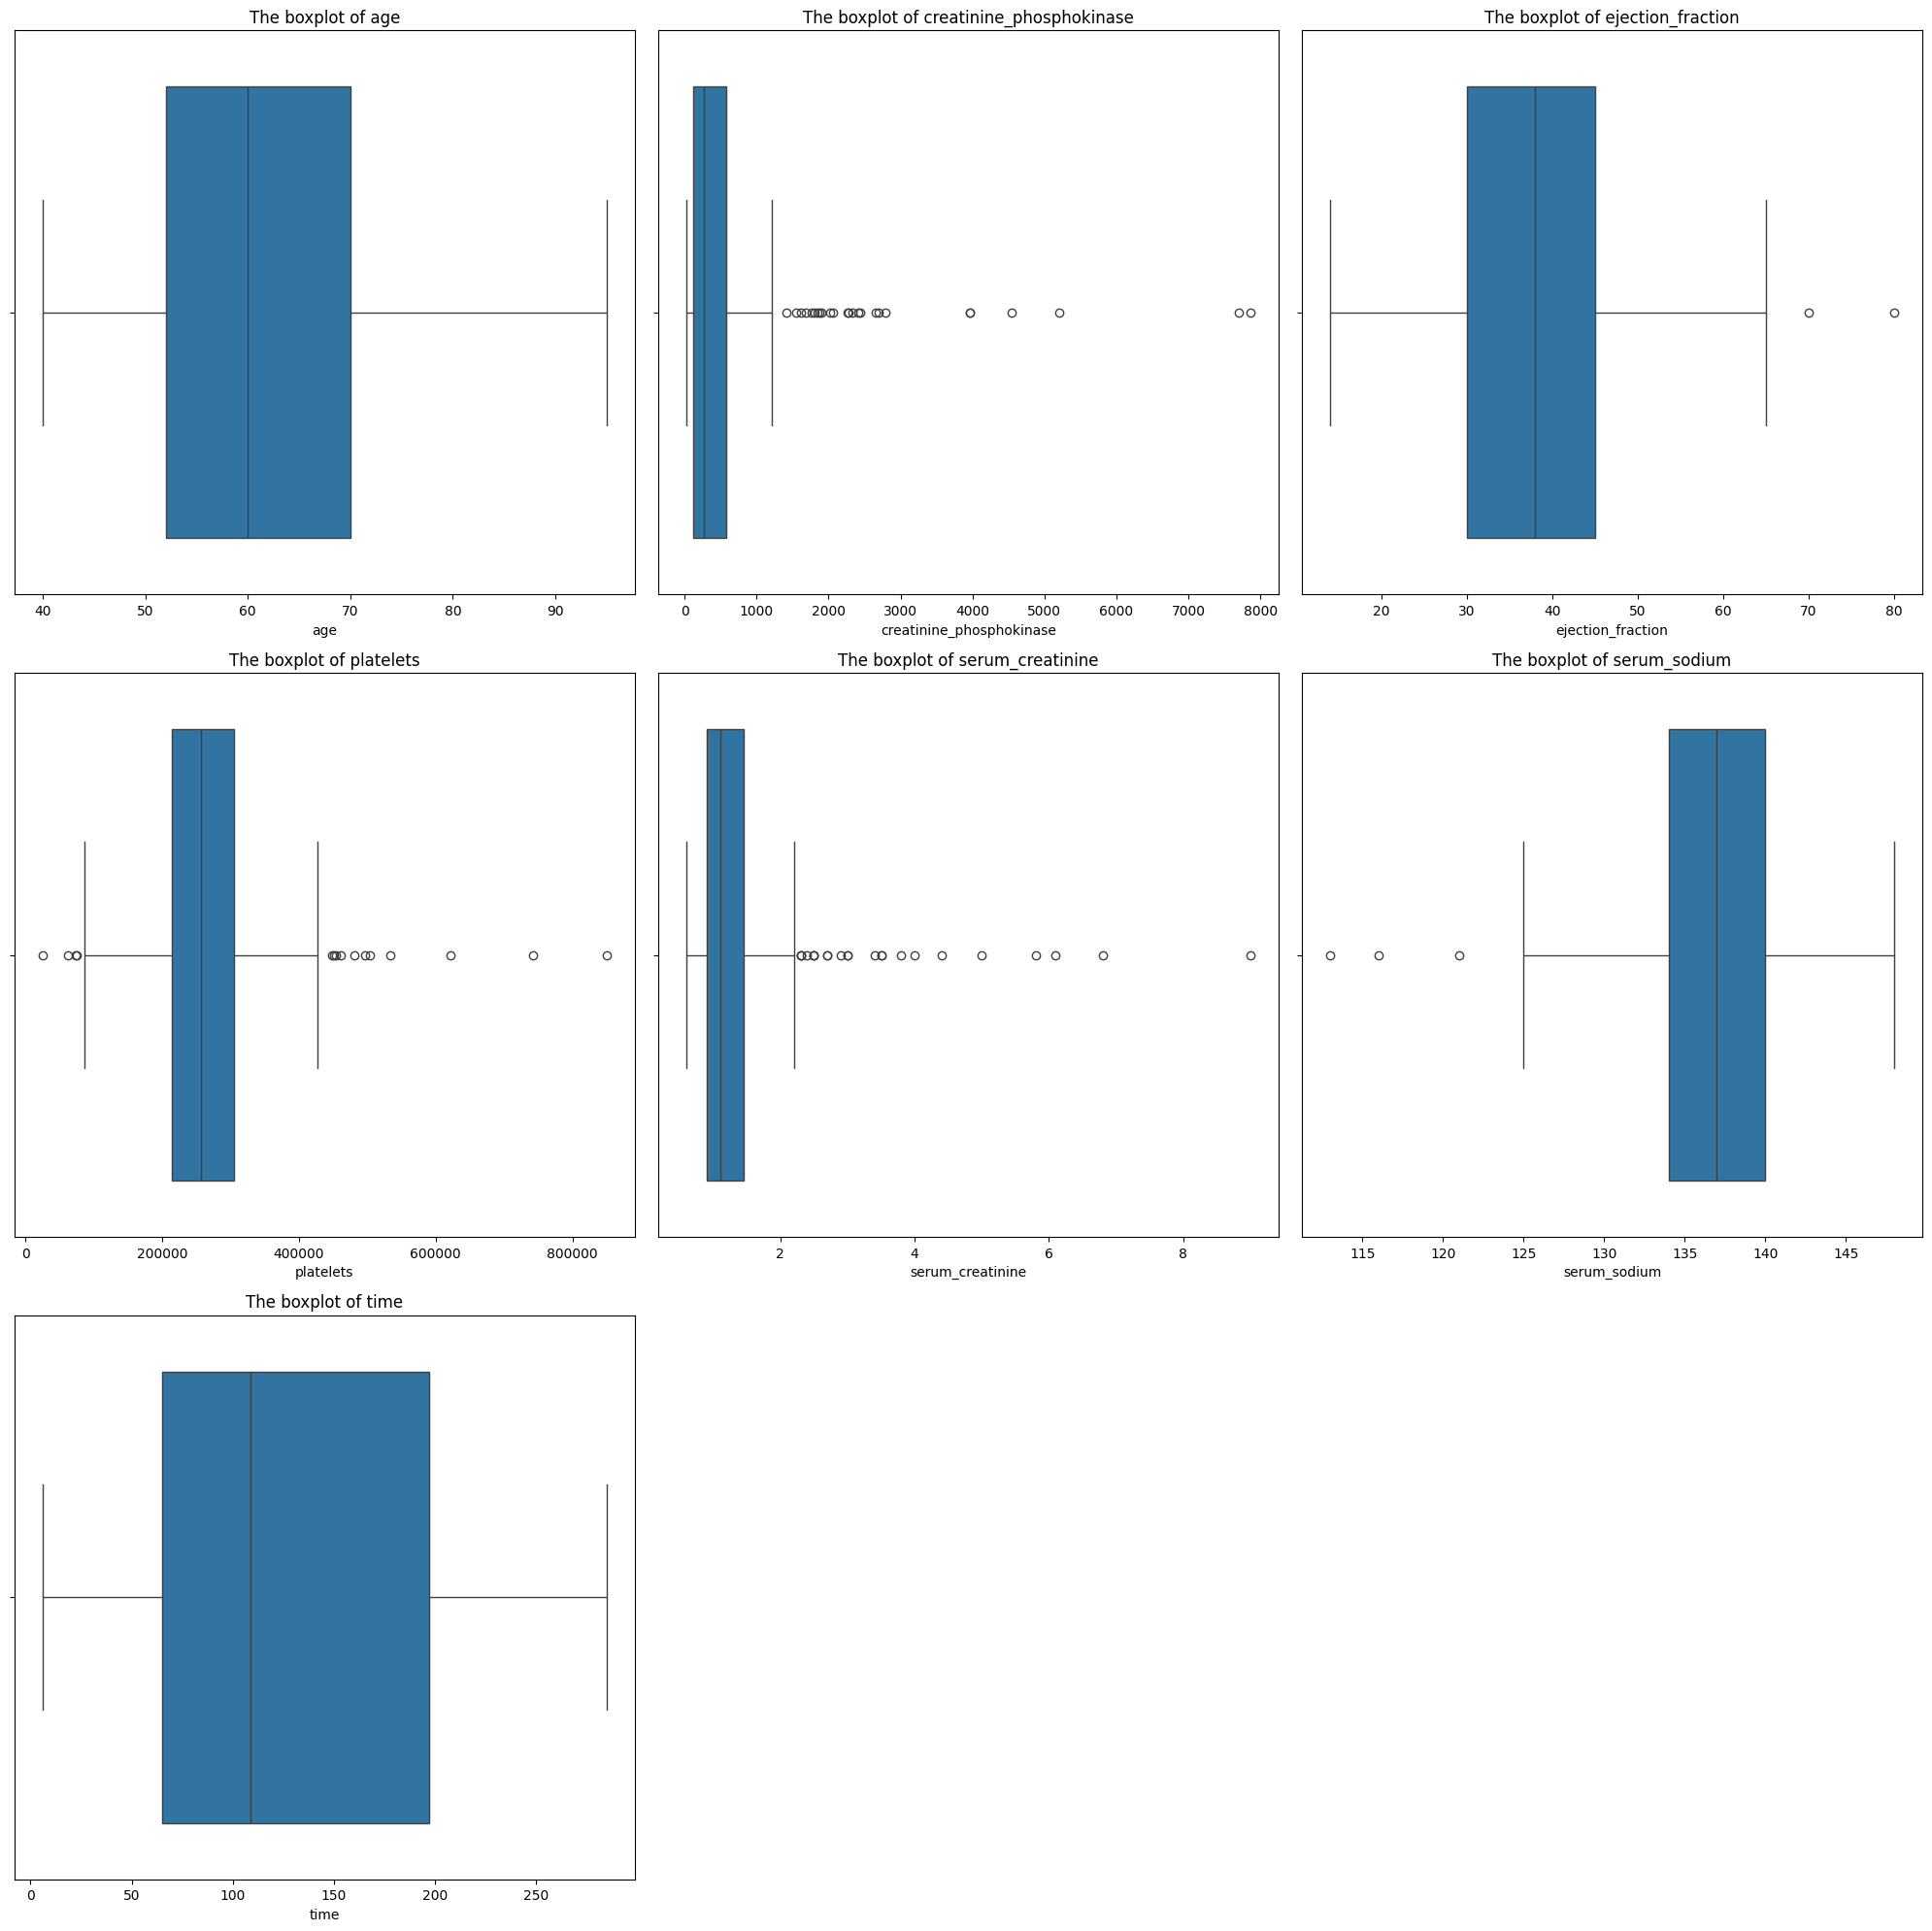

In [11]:
num_vars = train_df.columns.difference(['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking', 'DEATH_EVENT'])

cat_vars = train_df.columns.difference(num_vars)


fig, ax = plt.subplots(3,3, figsize=(20,20))

ax = ax.flatten()

for i, var in enumerate(num_vars):

    sns.boxplot(data=train_df, x=var, ax=ax[i])

    ax[i].set_title(f'The boxplot of {var}')

for j in range(len(num_vars), len(ax)):
    fig.delaxes(ax[j])

plt.tight_layout()
plt.show()

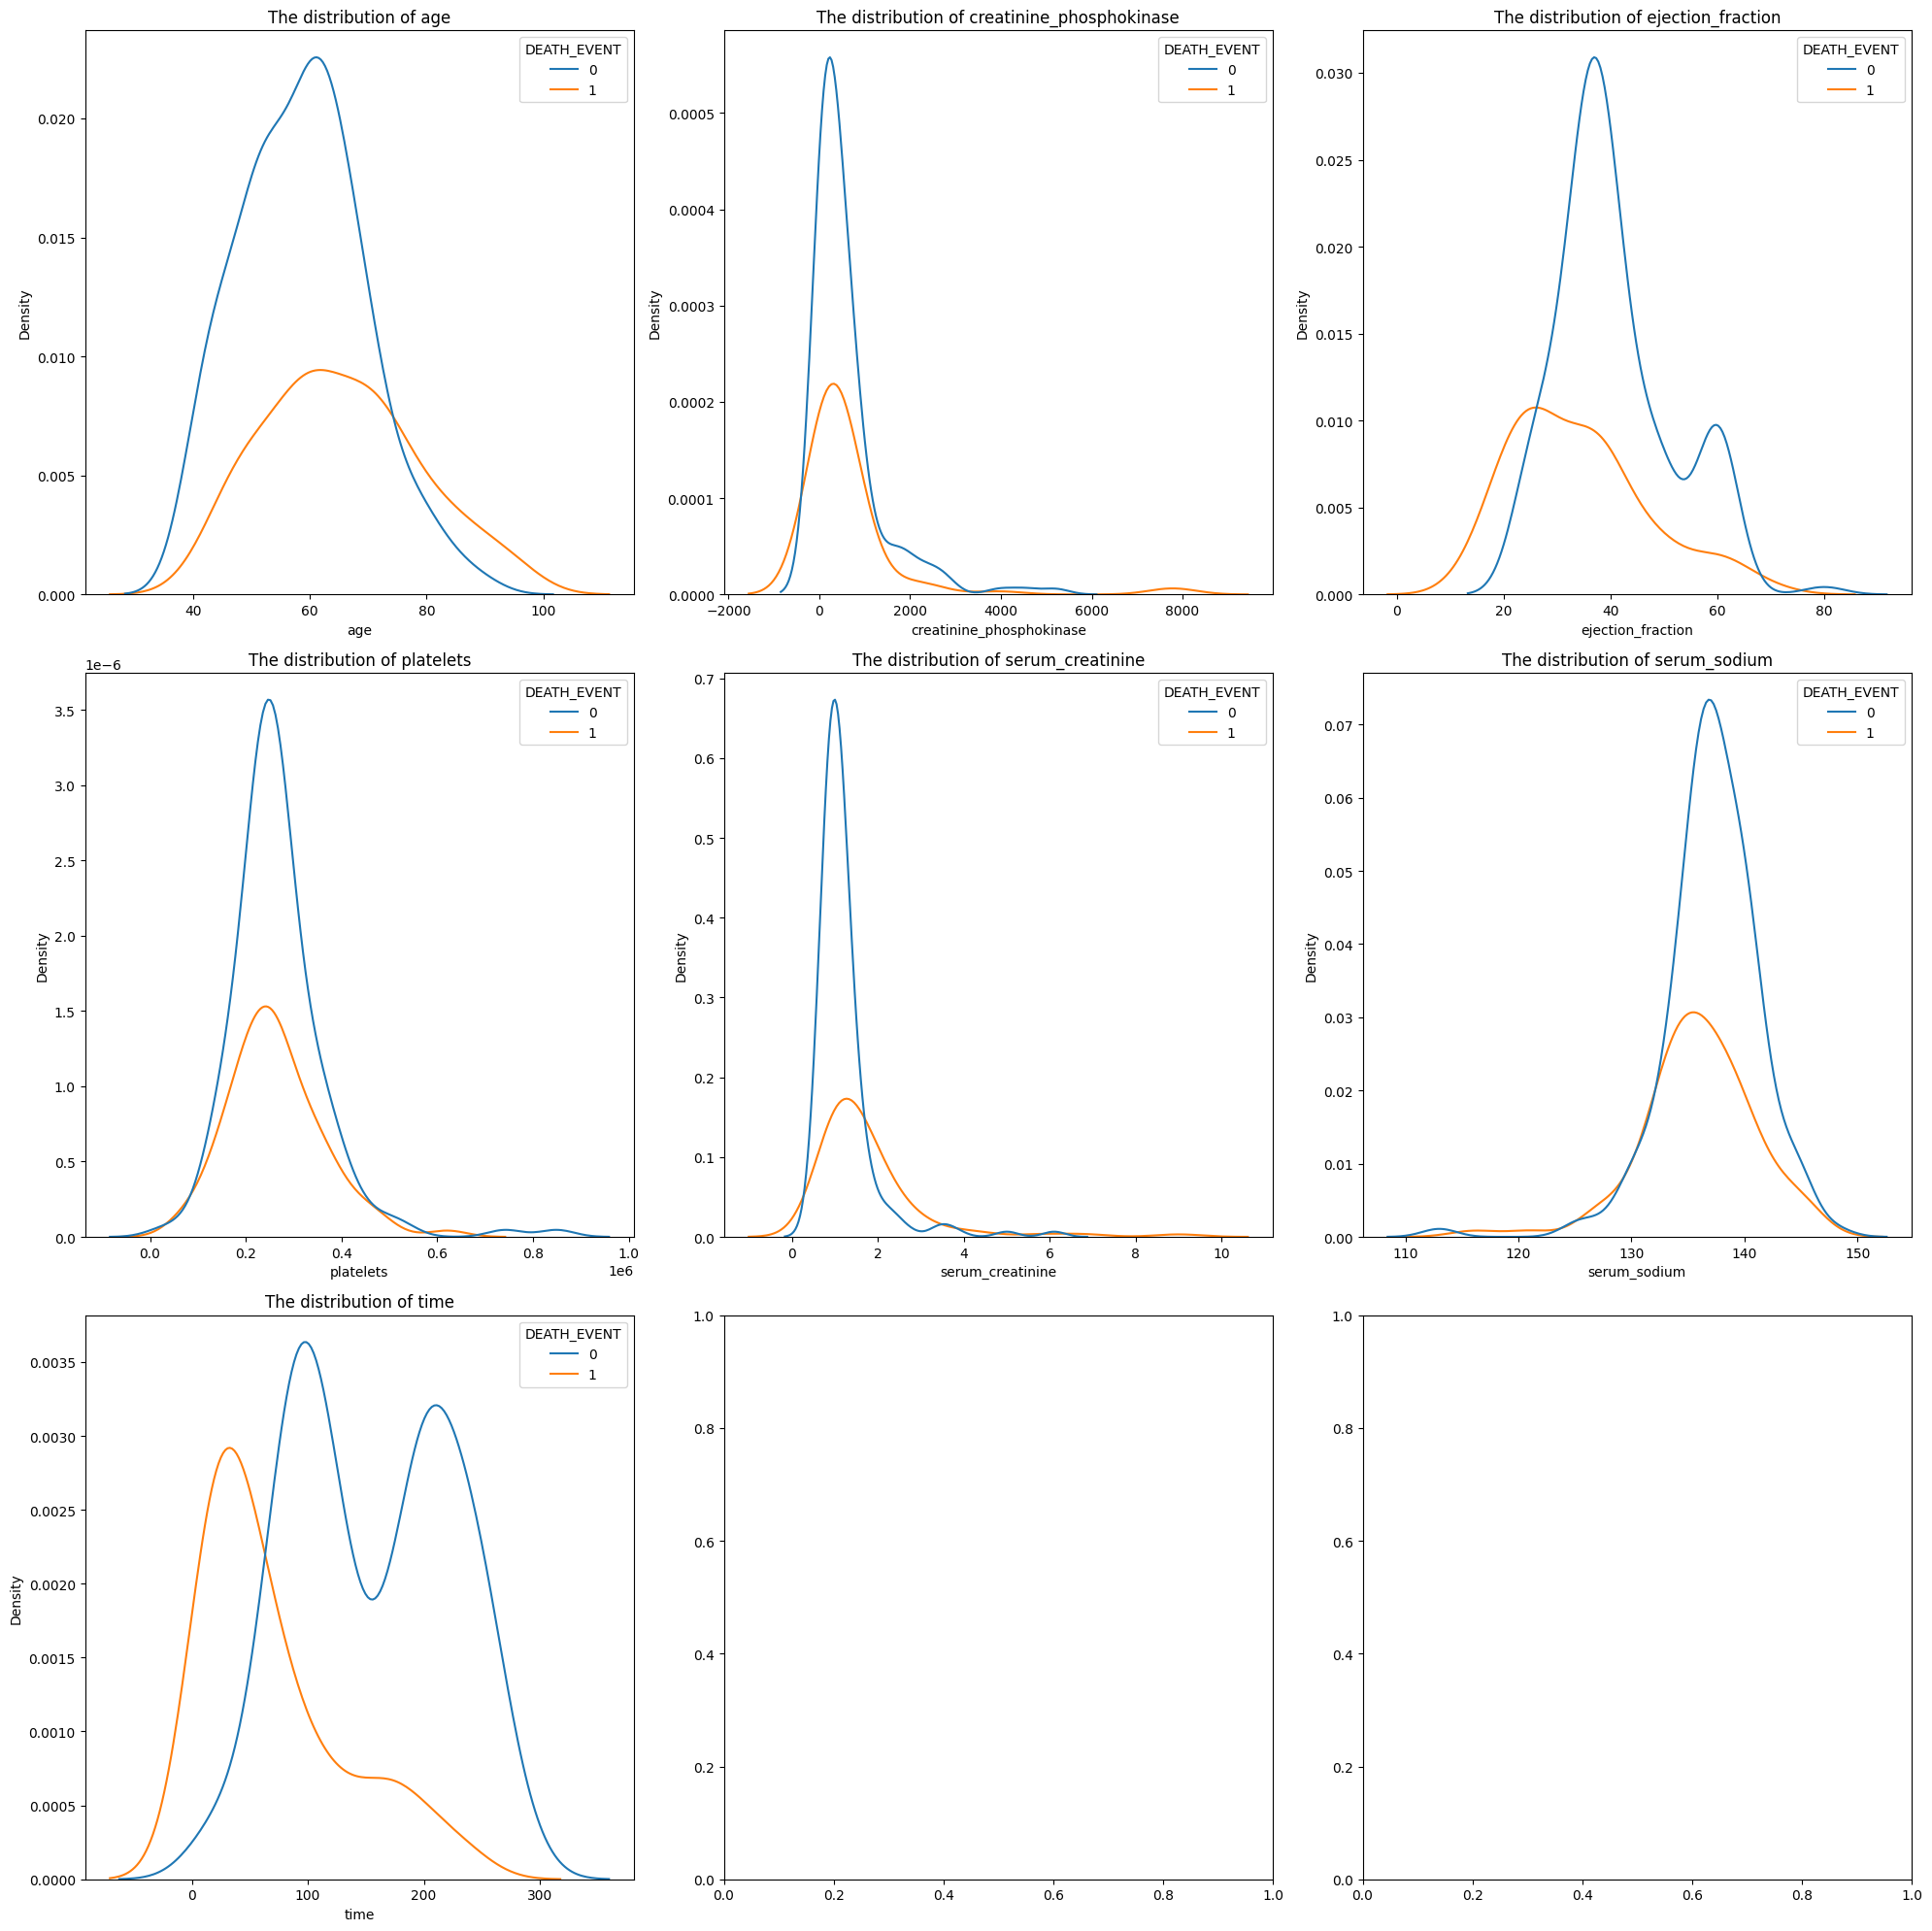

In [12]:
fig, ax = plt.subplots(3,3,figsize=(20,20))

ax = ax.flatten()

for i, var in enumerate(num_vars):
    sns.kdeplot(data=train_df, x=var, hue='DEATH_EVENT', ax=ax[i])
    ax[i].set_title(f'The distribution of {var}')

plt.tight_layout()

plt.show()

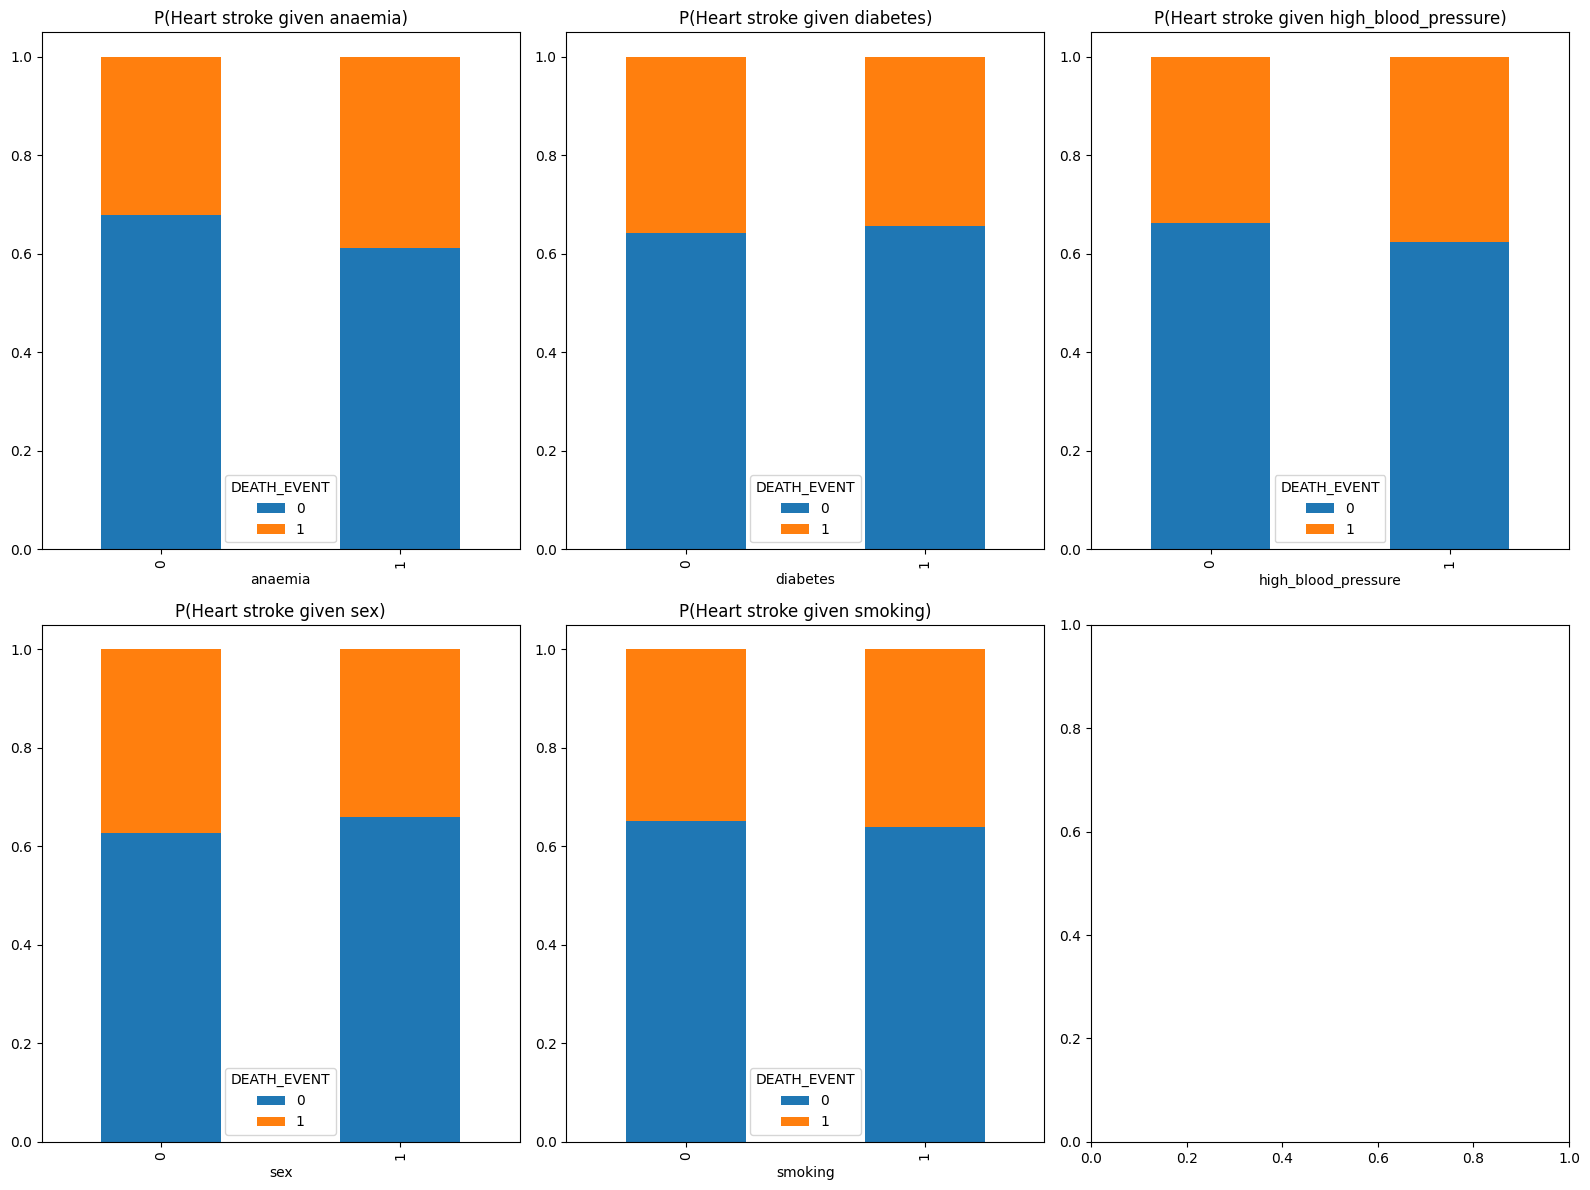

In [13]:
fig, ax = plt.subplots(2,3, figsize=(16,12))

ax = ax.flatten()

cat_vars = train_df.columns.difference(num_vars).difference(['DEATH_EVENT'])

for i, var in enumerate(cat_vars):
    pd.crosstab(train_df[var], train_df['DEATH_EVENT'], normalize='index').plot(kind='bar', stacked=True, ax=ax[i])
    ax[i].set_title(f'P(Heart stroke given {var})')

plt.tight_layout()

plt.show()

Checking for correlations

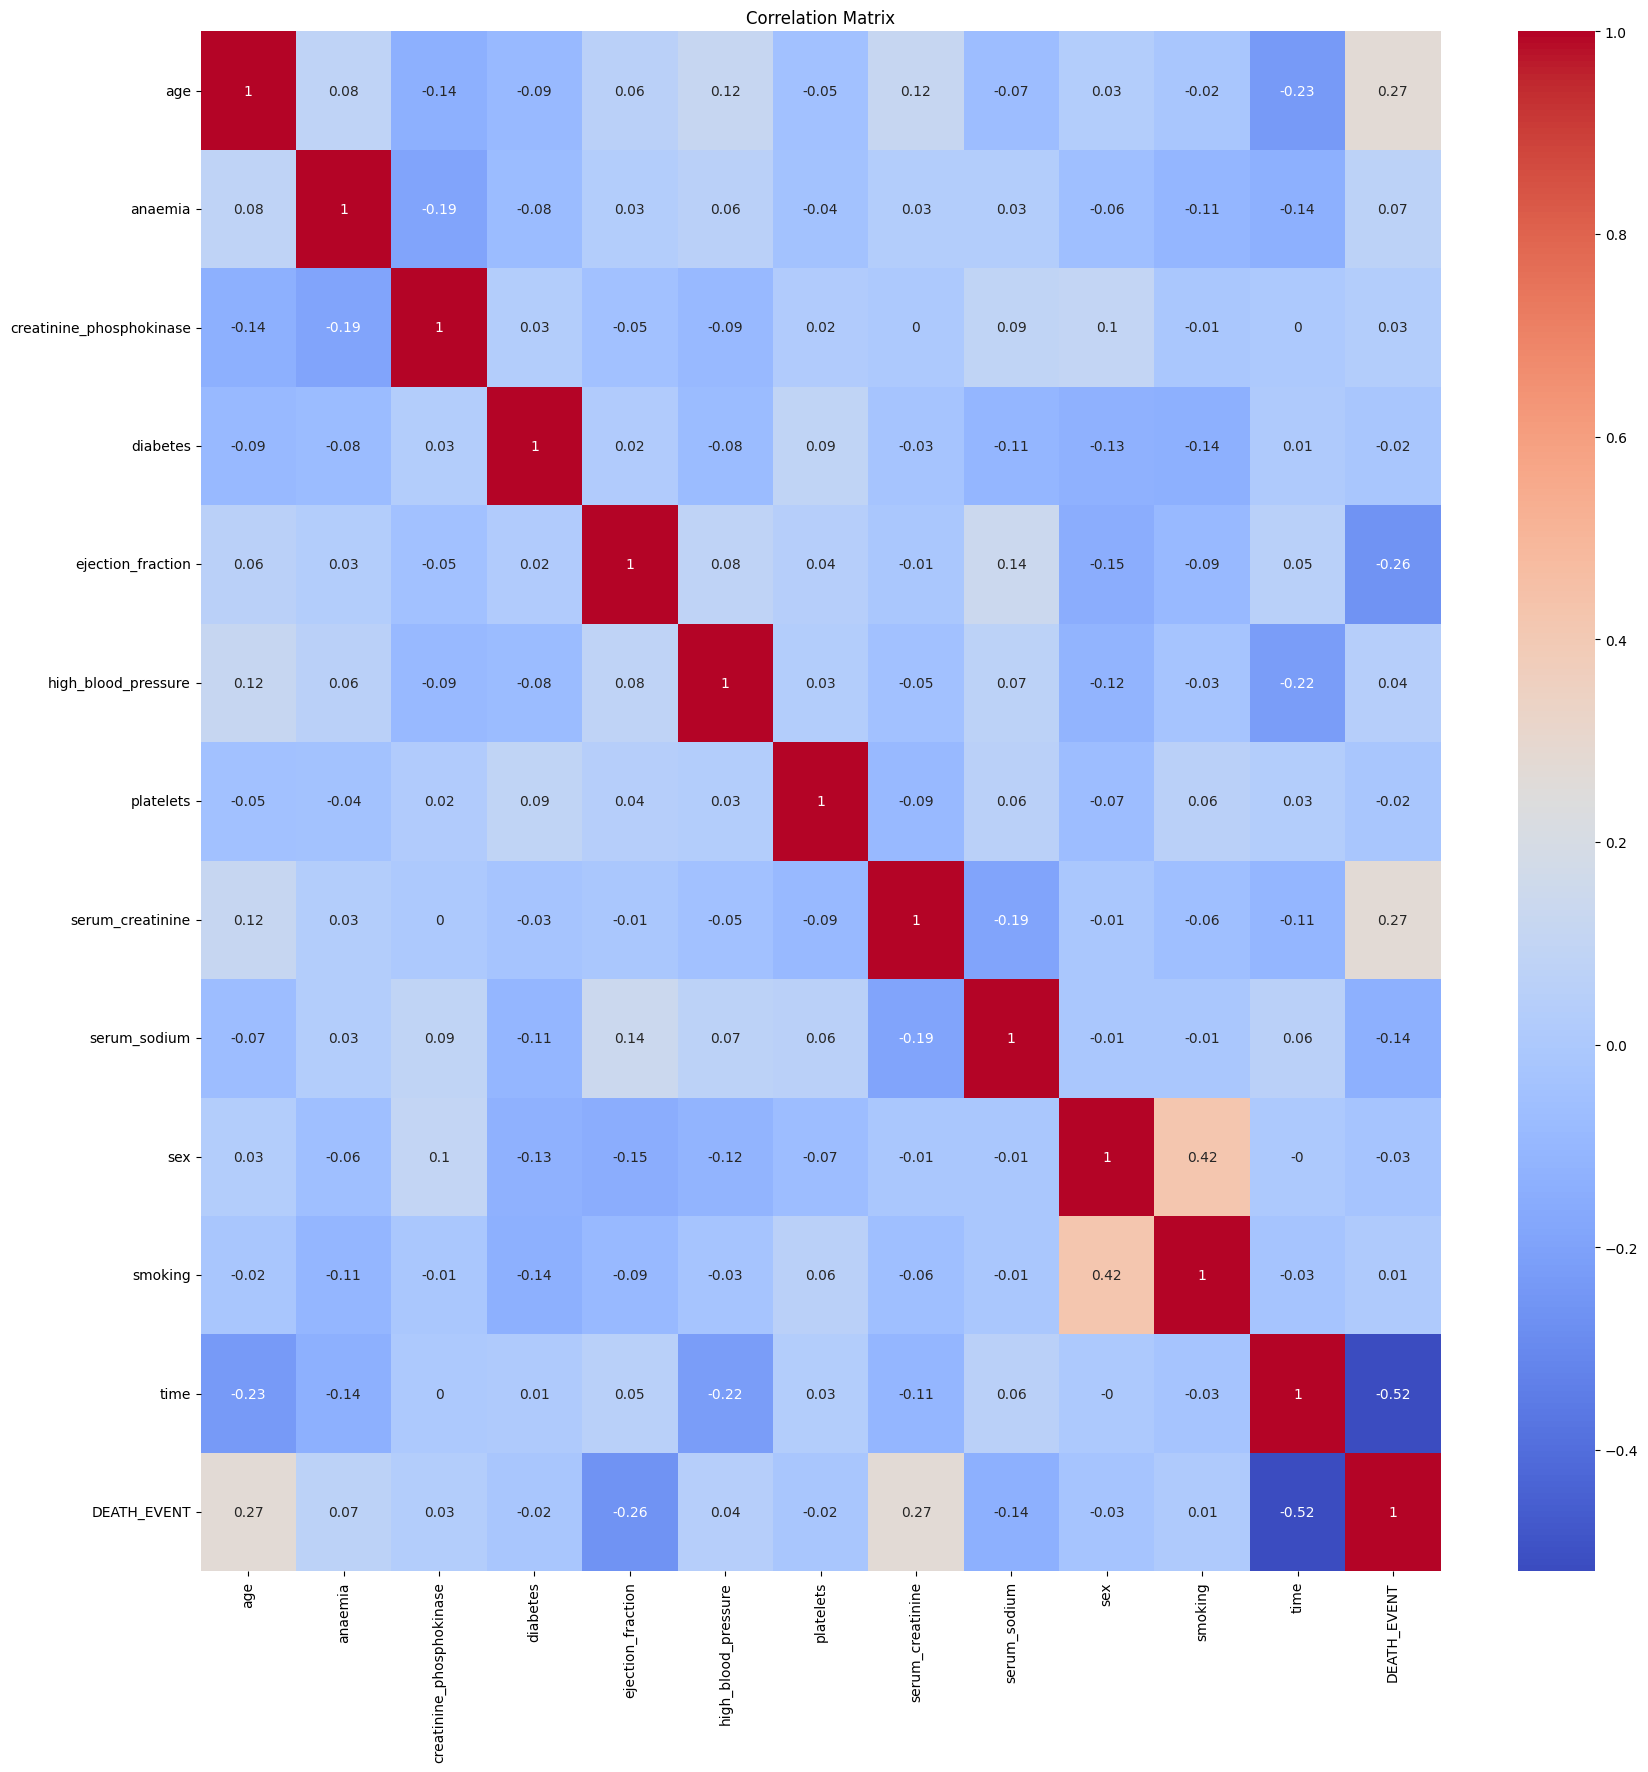

In [14]:
plt.figure(figsize=(20, 20))
sns.heatmap(round(train_df.corr(),2), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

#### PCA
Principal component analysis (PCA) reduce numărul de dimensiuni în seturi de date la componente principale care păstrează cea mai mare parte a informației originale. Acest lucru se realizează prin transformarea variabilelor potențial corelate într-un set mai mic de variabile, numit componente principale.

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

StandardScaler: Acesta este utilizat pentru a standardiza datele prin scalarea caracteristicilor astfel încât să aibă o medie de 0 și o deviație standard de 1. Standardizarea este esențială pentru PCA, care este sensibil la scara caracteristicilor.

In [16]:
# Reduce dimensions
reduced_variables = ['time','ejection_fraction','age','serum_creatinine','creatinine_phosphokinase','sex','smoking','serum_sodium','high_blood_pressure']
pca_ready = train_df[reduced_variables]

# Scaled data

scaler = StandardScaler()

pca_ready = scaler.fit_transform(pca_ready)

In [17]:
pca = PCA()

train_pca_fitted = pca.fit_transform(pca_ready)

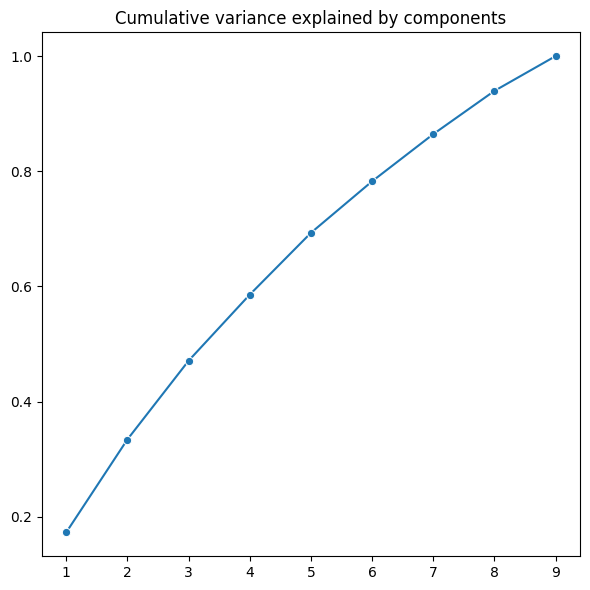

In [18]:
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

fig, ax = plt.subplots(figsize=(6,6))

sns.lineplot(x= range(1,len(cumulative_variance)+1), y=cumulative_variance, ax=ax, marker='o')

plt.title(f'Cumulative variance explained by components')

plt.tight_layout()

plt.show()

In [19]:
#Refit with n_components = 6 to capture 80% variance of original training data

pca = PCA(n_components=6)

train_pca_fitted = pca.fit_transform(pca_ready)

test_pca_fitted = pca.transform(scaler.transform(X_test[reduced_variables]))

In [20]:
train_pca_fitted = pd.DataFrame(train_pca_fitted, columns=['PC1','PC2','PC3','PC4','PC5','PC6'])

train_pca_fitted['DEATH_EVENT'] = train_df['DEATH_EVENT']

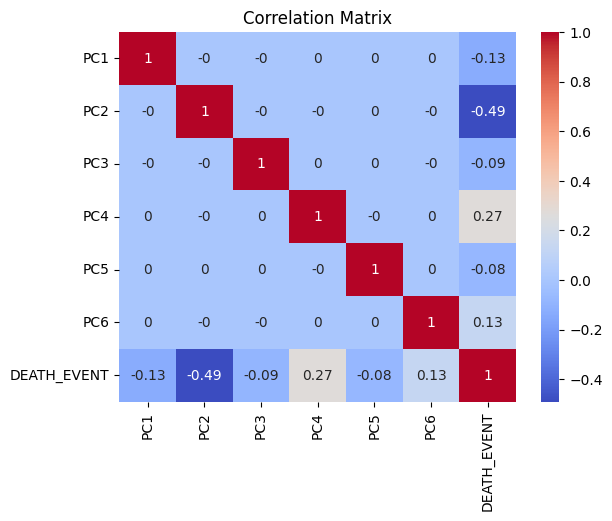

In [21]:
train_pca_fitted.corr()

sns.heatmap(round(train_pca_fitted.corr(),2), annot=True, cmap='coolwarm')

plt.title('Correlation Matrix')

plt.show()

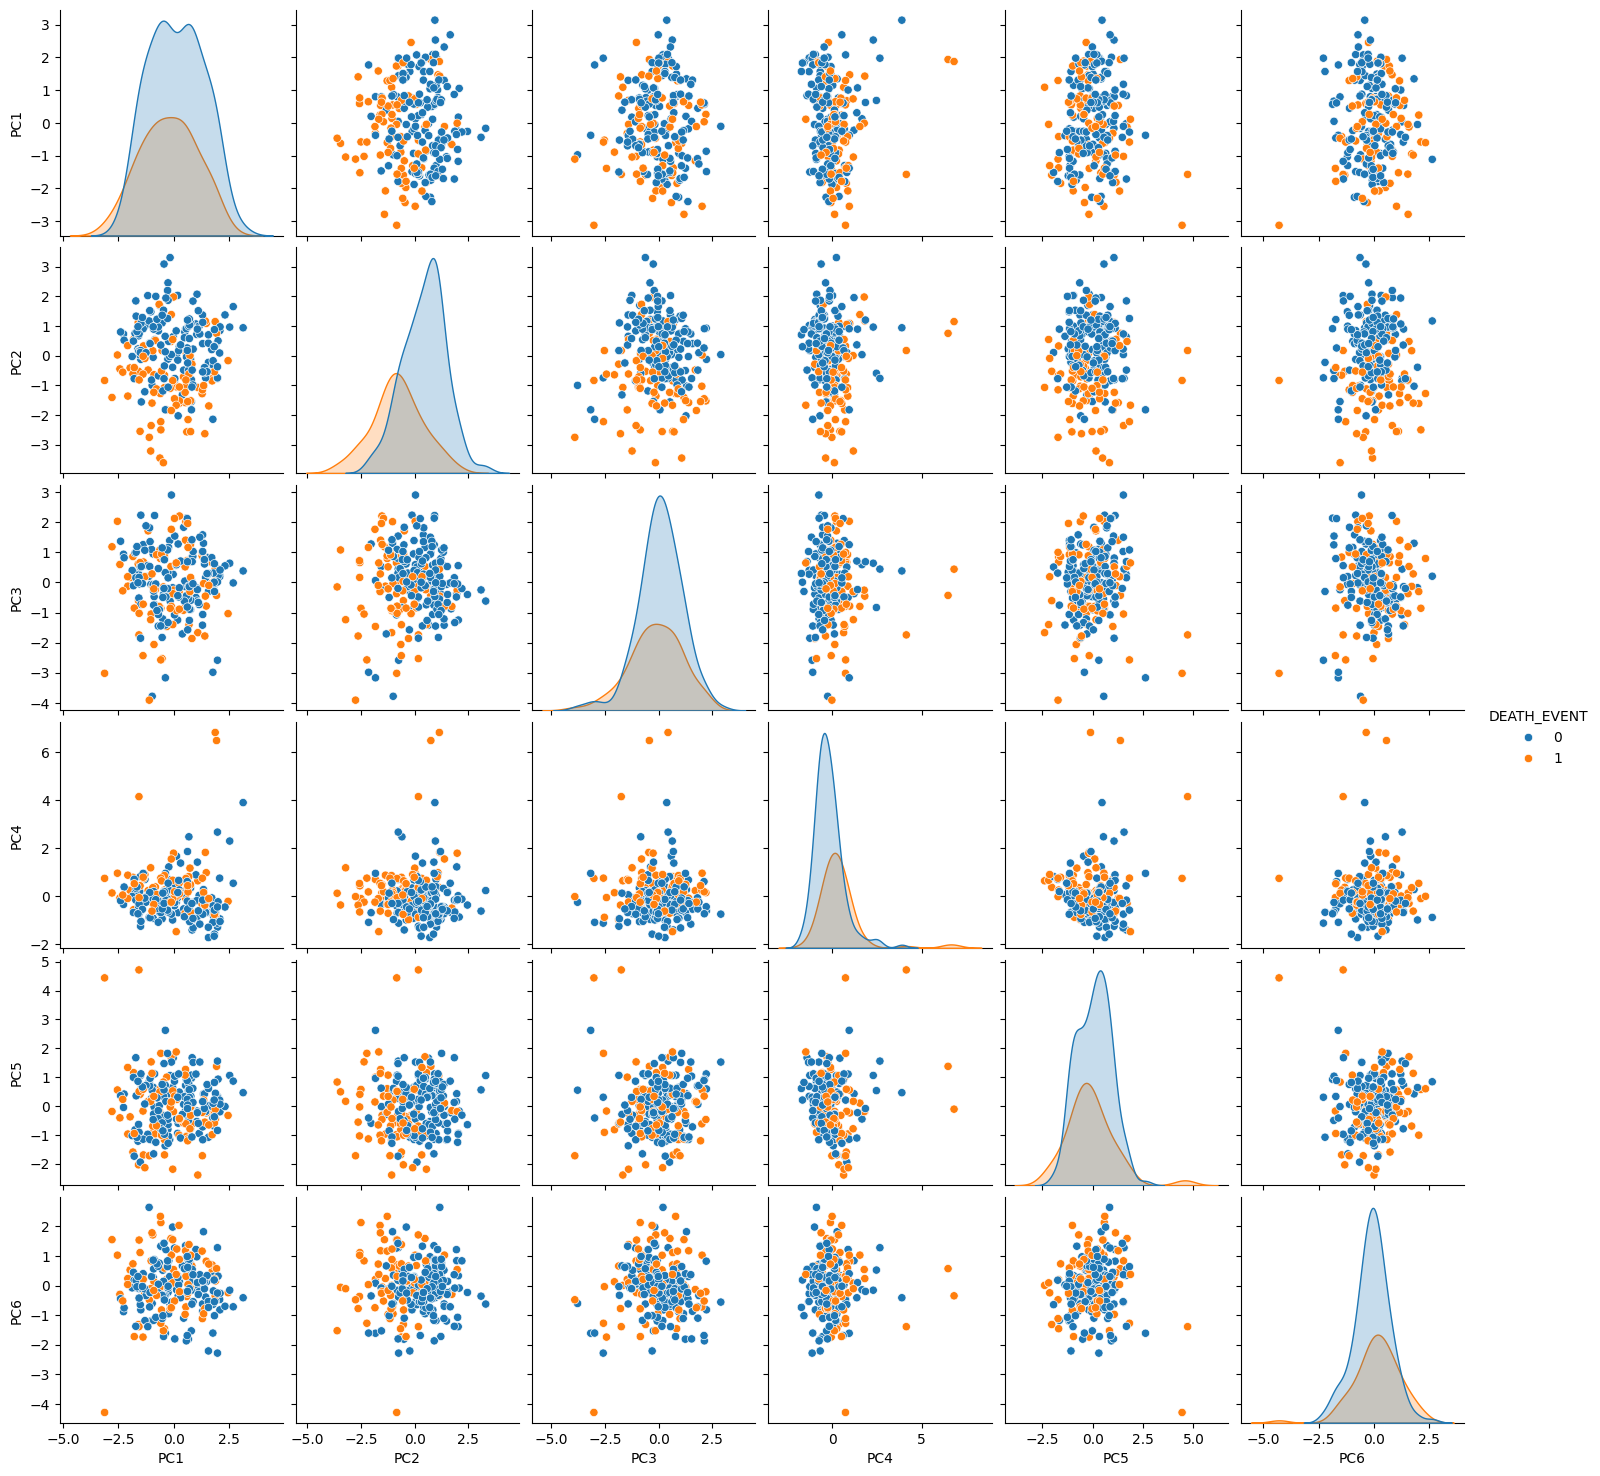

In [22]:
sns.pairplot(data=train_pca_fitted, hue='DEATH_EVENT')


### Model Training

In [23]:
premodel_scaler = StandardScaler()

X_train_scaled = premodel_scaler.fit_transform(X_train[reduced_variables])
X_test_scaled = premodel_scaler.transform(X_test[reduced_variables])

In [24]:
X_train_scaled.shape, X_test_scaled.shape

((239, 9), (60, 9))

In [25]:
!pip install xgboost

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

### Exercițiul 1

Definiti urmatoarele modele de clasificare

In [27]:
Models = {

    'Logistic Regression': LogisticRegression(penalty='l2', C=0.02),

    'Decision Tree': DecisionTreeClassifier(max_depth=7),

    'Random Forest': RandomForestClassifier(n_estimators=500, max_depth=10),

    'KNN': KNeighborsClassifier(n_neighbors=5),

    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),

    'Naive Bayes': GaussianNB()
}

### Exercițiul 2

a) Antrenează modelul: Folosește metoda fit() pentru a antrena modelul specificat pe datele de antrenament scalate, X_train_scaled și etichetele de antrenament, y_train.

b) Utilizează metoda predict() pentru a genera predicții pe setul de testare scalat, X_test_scaled.

c) Stochează în dicționarul results numele modelului ca cheie și un tuplu care conține recall-ul și precision-ul obținut pe setul de testare.

In [31]:
results = {}

for model_name, model in Models.items():

    # TO DO a)
    model.fit(X_train_scaled, y_train)

    y_pred = model.predict(X_test_scaled)

    results[model_name] = (recall_score(y_test, y_pred), precision_score(y_test, y_pred))

print("Recall, Precision")
results

Recall, Precision


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [08:46:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


{'Logistic Regression': (0.75, 1.0),
 'Decision Tree': (0.5833333333333334, 0.4666666666666667),
 'Random Forest': (0.6666666666666666, 0.7272727272727273),
 'KNN': (0.6666666666666666, 0.5333333333333333),
 'XGBoost': (0.75, 0.8181818181818182),
 'Naive Bayes': (0.75, 0.9)}

In [32]:
# Results on original data without PCA

results = {}

for model_name, model in Models.items():

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    results[model_name] = (recall_score(y_test, y_pred, pos_label=1), precision_score(y_test, y_pred, pos_label=1))

print("Recall, Precision")
results

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Recall, Precision


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [08:46:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


{'Logistic Regression': (0.5833333333333334, 0.6363636363636364),
 'Decision Tree': (0.5, 0.35294117647058826),
 'Random Forest': (0.75, 0.75),
 'KNN': (0.4166666666666667, 0.3333333333333333),
 'XGBoost': (0.6666666666666666, 0.6666666666666666),
 'Naive Bayes': (0.6666666666666666, 0.8)}

L1 regularization (Lasso regularization) adds a penalty equal to the absolute values of the coefficients, which can shrink some coefficients to exactly zero, effectively performing feature selection.

L2 regularization (Ridge regularization) adds a penalty equal to the sum of the squares of the coefficients. This discourages large coefficient values, effectively shrinking them towards zero without making them exactly zero. L2 regularization generally helps in cases where the features have a moderate level of collinearity.

C=0.05 controls the strength of regularization. Smaller values of C mean stronger regularization.
In general, this configuration helps produce a simpler model that generalizes better to new data, especially when working with datasets where there is a risk of overfitting or noisy features.

In [33]:
best_model = LogisticRegression(penalty='l2',C=.02)
best_model.fit(X_train_scaled, y_train)
y_pred = best_model.predict(X_test_scaled)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred, pos_label=1)}')
print(f'Recall: {recall_score(y_test, y_pred, pos_label=1)}')
print(f'F1 score: {f1_score(y_test, y_pred, pos_label=1)}')

Accuracy: 0.95
Precision: 1.0
Recall: 0.75
F1 score: 0.8571428571428571


### Exercițiul 3
Afisati matricea de confuzie pentru predictia realizata cu modelul best_model

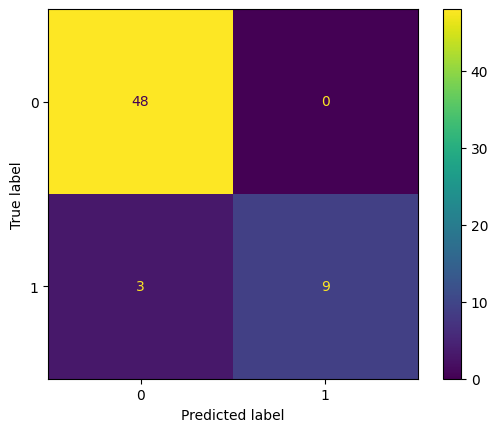

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# TO DO
cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot()
plt.show()

### Neural Networks

Diferite tipuri de optimizatori, functii de loss

In [35]:
!pip install split-folders

In [36]:
import os # A module that provides a way to interact with the operating system, allowing for tasks such as file and directory manipulation.
import torch
from PIL import Image # A module from the Python Imaging Library (PIL) that provides functionality for opening, manipulating, and saving various image file formats.
from torch.utils.data import Dataset # A PyTorch class that represents a dataset and provides an interface for accessing and processing the data during training.
import torchvision
import torchvision.transforms as transforms # A module from the torchvision library that provides common image transformations, such as resizing, cropping, and normalization.
from torch.utils.data import random_split # A function from PyTorch that allows for randomly splitting a dataset into training and validation subsets.
from torch.optim.lr_scheduler import ReduceLROnPlateau # A PyTorch scheduler that adjusts the learning rate during training based on a specified metric, reducing it when the metric plateaus.
import torch.nn as nn # A module in PyTorch that provides classes for defining and building neural networks.
from torchvision import utils # A module from torchvision that contains utility functions for working with images, such as saving and visualizing them.
from torchvision.datasets import ImageFolder
import splitfolders
from torchsummary import summary
import torch.nn.functional as F
import pathlib
from sklearn.metrics import confusion_matrix, classification_report
import itertools # This import statement imports the itertools module, which provides functions for efficient looping and combining of iterables. It can be used for tasks such as generating combinations or permutations of elements.
from tqdm.notebook import trange, tqdm # These functions allow for the creation of progress bars to track the progress of loops or tasks.
from torch import optim
import warnings
warnings.filterwarnings('ignore')

#### Dataset
Citirea datelor

In [37]:
labels_df = pd.read_csv('Data/metadata.csv')
print(labels_df.head().to_markdown())

|    |   Unnamed: 0 | image           | class   | format   | mode   | shape         |
|---:|-------------:|:----------------|:--------|:---------|:-------|:--------------|
|  0 |            0 | Cancer (1).jpg  | tumor   | JPEG     | RGB    | (512, 512, 3) |
|  1 |            1 | Cancer (1).png  | tumor   | PNG      | L      | (300, 240)    |
|  2 |            2 | Cancer (1).tif  | tumor   | TIFF     | RGB    | (256, 256, 3) |
|  3 |            3 | Cancer (10).jpg | tumor   | JPEG     | RGB    | (512, 512, 3) |
|  4 |            4 | Cancer (10).tif | tumor   | TIFF     | RGB    | (256, 256, 3) |


In [38]:
os.listdir('Data/Brain Tumor Data Set')


['Brain Tumor', 'Healthy']

In [39]:
labels_df.shape

(4600, 6)

Procesarea setului de date

In [40]:
data_dir = 'Data/Brain Tumor Data Set'
data_dir = pathlib.Path(data_dir)

splitfolders.ratio(data_dir, output='brain', seed=20, ratio=(0.8, 0.2))

data_dir = 'brain'
data_dir = pathlib.Path(data_dir)

Copying files: 4600 files [00:00, 7133.88 files/s]


### Exercițiul 4
Creează o variabilă numită transform, care să conțină o secvență de transformări aplicate fiecărei imagini, după cum urmează:

Redimensionare: Redimensionează fiecare imagine la 256x256 pixeli.

Flip orizontal: Aplică o întoarcere orizontală aleatorie, cu probabilitatea de 50%.

Flip vertical: Aplică o întoarcere verticală aleatorie, cu probabilitatea de 50%.

Rotire aleatorie: Aplică o rotație aleatorie în intervalul de ±30 de grade.

Conversie în tensor: Convertește imaginea într-un tensor utilizabil de PyTorch.

Normalizare: Normalizează valorile pixelilor folosind media [0.485, 0.456, 0.406] și deviația standard [0.229, 0.224, 0.225], pentru a asigura compatibilitatea cu un model pre-antrenat.

Folosește transforms.Compose() pentru a crea acest pipeline de transformări și asignează-l variabilei transform.

In [41]:
# TO DO
transform = transforms.Compose(
    [
      transforms.Resize((256, 256)),
      transforms.RandomHorizontalFlip(p=0.5),
      transforms.RandomVerticalFlip(p=0.5),
      transforms.RandomRotation(degrees=30),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [42]:
train_set = torchvision.datasets.ImageFolder(data_dir.joinpath("train"), transform=transform)
train_set.transform
val_set = torchvision.datasets.ImageFolder(data_dir.joinpath("val"), transform=transform)
val_set.transform

Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

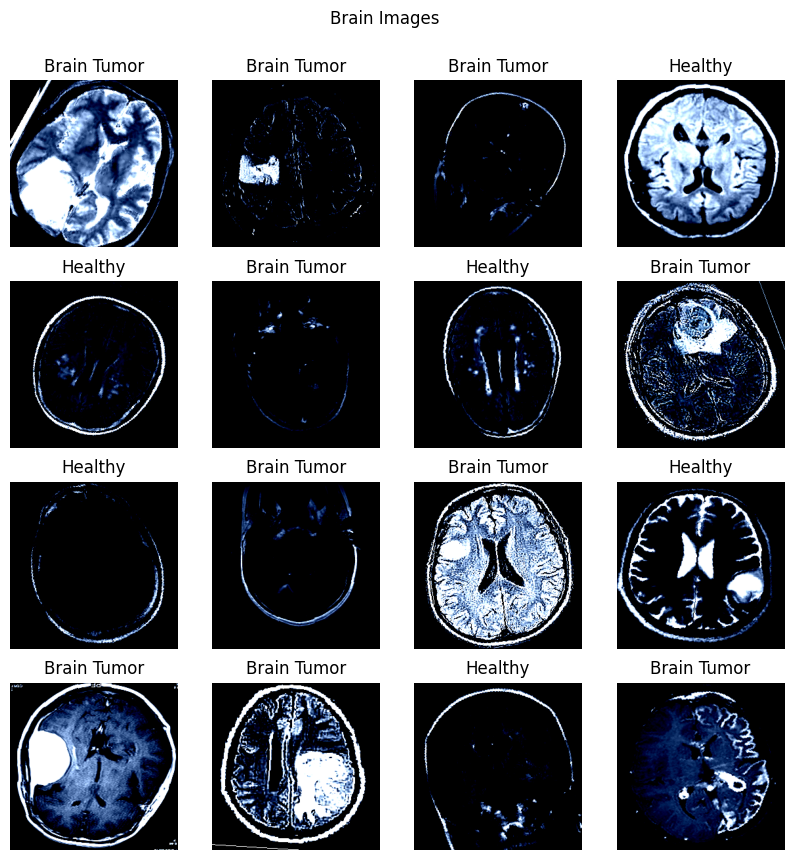

In [43]:
CLA_label = {
    0 : 'Brain Tumor',
    1 : 'Healthy'
}
figure = plt.figure(figsize=(10, 10))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_set), size=(1,)).item()
    img, label = train_set[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(CLA_label[label])
    plt.axis("off")
    img_np = img.numpy().transpose((1, 2, 0))
    # Clip pixel values to [0, 1]
    img_valid_range = np.clip(img_np, 0, 1)
    plt.imshow(img_valid_range)
    plt.suptitle('Brain Images', y=0.95)
plt.show()

Dataloaders

In [44]:
batch_size = 64

train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True, num_workers = 2)
val_loader = torch.utils.data.DataLoader(val_set, batch_size = batch_size, shuffle = True, num_workers = 2)

In [45]:
for key, value in {'Training data': train_loader, "Validation data": val_loader}.items():
    for X, y in value:
        print(f"{key}:")
        print(f"Shape of X : {X.shape}")
        print(f"Shape of y: {y.shape} {y.dtype}\n")
        break

Training data:
Shape of X : torch.Size([64, 3, 256, 256])
Shape of y: torch.Size([64]) torch.int64

Validation data:
Shape of X : torch.Size([64, 3, 256, 256])
Shape of y: torch.Size([64]) torch.int64



#### Arhitectura

In [46]:
'''This function can be useful in determining the output size of a convolutional layer in a neural network,
given the input dimensions and the convolutional layer's parameters.'''

def findConv2dOutShape(hin,win,conv,pool=2):
    # get conv arguments
    kernel_size = conv.kernel_size
    stride=conv.stride
    padding=conv.padding
    dilation=conv.dilation

    hout=np.floor((hin+2*padding[0]-dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
    wout=np.floor((win+2*padding[1]-dilation[1]*(kernel_size[1]-1)-1)/stride[1]+1)

    if pool:
        hout/=pool
        wout/=pool
    return int(hout),int(wout)

In [47]:
class CNN_TUMOR(nn.Module):

    def __init__(self, params):

        super(CNN_TUMOR, self).__init__()

        Cin,Hin,Win = params["shape_in"]
        init_f = params["initial_filters"]
        num_fc1 = params["num_fc1"]
        num_classes = params["num_classes"]
        self.dropout_rate = params["dropout_rate"]

        self.conv1 = nn.Conv2d(Cin, init_f, kernel_size=3)
        h,w=findConv2dOutShape(Hin,Win,self.conv1)
        self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv2)
        self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv3)
        self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv4)

        self.num_flatten=h*w*8*init_f
        self.fc1 = nn.Linear(self.num_flatten, num_fc1)
        self.fc2 = nn.Linear(num_fc1, num_classes)

    def forward(self,X):

        X = F.relu(self.conv1(X));
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv4(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, self.num_flatten)
        X = F.relu(self.fc1(X))
        X = F.dropout(X, self.dropout_rate)
        X = self.fc2(X)
        return F.log_softmax(X, dim=1)

### Exercițiul 5
Instanțiați rețeaua și asigurați-vă că aceasta rulează pe un GPU, dacă acesta este disponibil.

In [49]:
params_model={
        "shape_in": (3,256,256),
        "initial_filters": 8,
        "num_fc1": 100,
        "dropout_rate": 0.25,
        "num_classes": 2}

cnn_model = CNN_TUMOR(params_model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = cnn_model.to(device)

In [50]:
summary(cnn_model, input_size=(3, 256, 256),device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 254, 254]             224
            Conv2d-2         [-1, 16, 125, 125]           1,168
            Conv2d-3           [-1, 32, 60, 60]           4,640
            Conv2d-4           [-1, 64, 28, 28]          18,496
            Linear-5                  [-1, 100]       1,254,500
            Linear-6                    [-1, 2]             202
Total params: 1,279,230
Trainable params: 1,279,230
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.75
Forward/backward pass size (MB): 7.11
Params size (MB): 4.88
Estimated Total Size (MB): 12.74
----------------------------------------------------------------


### Exercițiul 6
Definiți funcția de pierdere (*loss function*) și optimizatorul Adam cu valoarea parametrului learning rate = 3e-4 pentru antrenarea modelului.

In [ ]:
loss_func =  nn.NLLLoss(reduction="sum")# Definti negative log likelihood loss cu parametrul reduction="sum"

In [52]:
opt = optim.AdamW(model.parameters(), lr=0.001) # Adam optimizer
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20)

In [53]:
# Function to get the learning rate
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

# Function to compute the loss value per batch of data
def loss_batch(loss_func, output, target, opt=None):

    loss = loss_func(output, target) # get loss
    pred = output.argmax(dim=1, keepdim=True) # Get Output Class
    metric_b=pred.eq(target.view_as(pred)).sum().item() # get performance metric

    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

# Compute the loss value & performance metric for the entire dataset (epoch)
def loss_epoch(model,loss_func,dataset_dl,opt=None):

    run_loss=0.0
    t_metric=0.0
    len_data=len(dataset_dl.dataset)

    # internal loop over dataset
    for xb, yb in dataset_dl:
        # move batch to device
        xb=xb.to(device)
        yb=yb.to(device)
        output=model(xb) # get model output
        loss_b,metric_b=loss_batch(loss_func, output, yb, opt) # get loss per batch
        run_loss+=loss_b        # update running loss

        if metric_b is not None: # update running metric
            t_metric+=metric_b

    loss=run_loss/float(len_data)  # average loss value
    metric=t_metric/float(len_data) # average metric value

    return loss, metric

In [54]:
def Train_Val(model, params,verbose=False):

    # Get the parameters
    epochs=params["epochs"]
    loss_func=params["f_loss"]
    opt=params["optimiser"]
    train_dl=params["train"]
    val_dl=params["val"]
    lr_scheduler=params["lr_change"]
    weight_path=params["weight_path"]

    # history of loss values in each epoch
    loss_history={"train": [],"val": []}
    # histroy of metric values in each epoch
    metric_history={"train": [],"val": []}
    # a deep copy of weights for the best performing model
    best_model_wts = copy.deepcopy(model.state_dict())
    # initialize best loss to a large value
    best_loss=float('inf')

# Train Model n_epochs (the progress of training by printing the epoch number and the associated learning rate. It can be helpful for debugging, monitoring the learning rate schedule, or gaining insights into the training process.)

    for epoch in tqdm(range(epochs)):

        # Get the Learning Rate
        current_lr=get_lr(opt)
        if(verbose):
            print('Epoch {}/{}, current lr={}'.format(epoch, epochs - 1, current_lr))


# Train Model Process


        model.train()
        train_loss, train_metric = loss_epoch(model,loss_func,train_dl,opt)

        # collect losses
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)


# Evaluate Model Process


        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model,loss_func,val_dl)

        # store best model
        if(val_loss < best_loss):
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

            # store weights into a local file
            torch.save(model.state_dict(), weight_path)
            if(verbose):
                print("Copied best model weights!")

        # collect loss and metric for validation dataset
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)

        # learning rate schedule
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            if(verbose):
                print("Loading best model weights!")
            model.load_state_dict(best_model_wts)

        if(verbose):
            print(f"train loss: {train_loss:.6f}, dev loss: {val_loss:.6f}, accuracy: {100*val_metric:.2f}")
            print("-"*10)

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, loss_history, metric_history

In [60]:
import copy
# Define various parameters used for training and evaluation of a cnn_model

params_train={
 "train": train_loader,"val": val_loader,
 "epochs": 20,
 "optimiser": optim.AdamW(cnn_model.parameters(),lr=3e-4),
 "lr_change": ReduceLROnPlateau(opt,
                                mode='min',
                                factor=0.5,
                                patience=20),
 "f_loss": nn.NLLLoss(reduction="sum"),
 "weight_path": "weights.pt",
}

# train and validate the model
cnn_model,loss_hist,metric_hist = Train_Val(cnn_model,params_train)

  0%|          | 0/20 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0a2037b600>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0a2037b600>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

<Axes: >

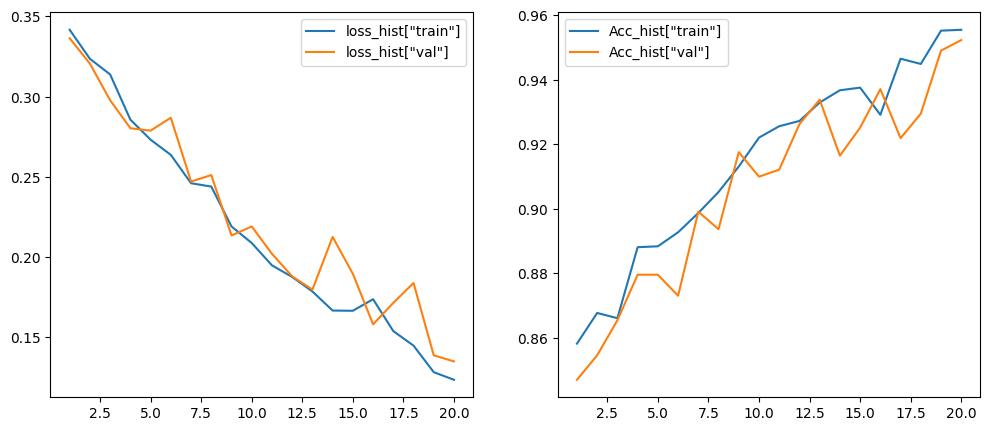

In [61]:
# Convergence History Plot
epochs=params_train["epochs"]
fig,ax = plt.subplots(1,2,figsize=(12,5))

sns.lineplot(x=[*range(1,epochs+1)],y=loss_hist["train"],ax=ax[0],label='loss_hist["train"]')
sns.lineplot(x=[*range(1,epochs+1)],y=loss_hist["val"],ax=ax[0],label='loss_hist["val"]')
sns.lineplot(x=[*range(1,epochs+1)],y=metric_hist["train"],ax=ax[1],label='Acc_hist["train"]')
sns.lineplot(x=[*range(1,epochs+1)],y=metric_hist["val"],ax=ax[1],label='Acc_hist["val"]')

In [62]:
# define function For Classification Report
def Ture_and_Pred(val_loader, model):
    i = 0
    y_true = []
    y_pred = []
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.numpy()
        outputs = model(images)
        _, pred = torch.max(outputs.data, 1)
        pred = pred.detach().cpu().numpy()

        y_true = np.append(y_true, labels)
        y_pred = np.append(y_pred, pred)

    return y_true, y_pred


# check confusion matrix for error analysis
y_true, y_pred = Ture_and_Pred(val_loader, cnn_model)

print(classification_report(y_true, y_pred), '\n\n')
cm = confusion_matrix(y_true, y_pred)

              precision    recall  f1-score   support

         0.0       0.96      0.95      0.95       503
         1.0       0.94      0.95      0.94       418

    accuracy                           0.95       921
   macro avg       0.95      0.95      0.95       921
weighted avg       0.95      0.95      0.95       921
 




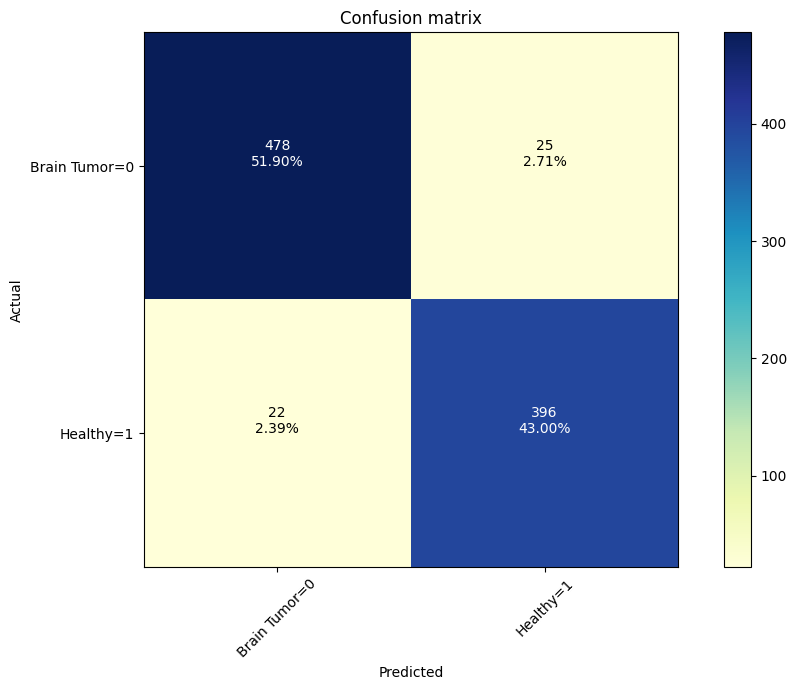

In [63]:
# Confusion Matrix Plotting Function
def show_confusion_matrix(cm, CLA_label, title='Confusion matrix', cmap=plt.cm.YlGnBu):

    plt.figure(figsize=(10,7))
    plt.grid(False)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(CLA_label))

    plt.xticks(tick_marks, [f"{value}={key}" for key , value in CLA_label.items()], rotation=45)
    plt.yticks(tick_marks, [f"{value}={key}" for key , value in CLA_label.items()])

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i,j]}\n{cm[i,j]/np.sum(cm)*100:.2f}%", horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()

show_confusion_matrix(cm, CLA_label)

In [64]:
torch.save(cnn_model, "Brain_Tumor_model.pt")